# Alice in Wonderland Degradation Experiment

This notebook conducts an experiment to study model performance degradation by adding Alice in Wonderland text to the context. The experiment uses **three variations**, each containing section_1 text:

1. **Section 1 only**: Just the section_1 text as context (3,000 token limit)
2. **Section 1 + Alice (10K)**: Section 1 text + Alice in Wonderland text (10,000 token limit)
3. **Section 1 + Alice (15K)**: Section 1 text + Alice in Wonderland text (15,000 token limit)

**Notebook Structure:**
1. **Setup** (Cells 0-3): Imports, dataset loading, model loading
2. **Sample Collection** (Cells 4-5): Collects 50 samples with incorporation state
3. **Helper Functions** (Cell 6): Context assembly, prompt building, answer normalization
4. **Alice Text Loading** (Cell 8): Downloads/loads Alice in Wonderland text
5. **Context Assembly Functions** (Cell 9): Functions to create the three context variations
6. **Logit Lens Function** (Cell 10): Enhanced function that returns probs, ranks, and top predictions
7. **Main Experiment** (Cell 11): Runs logit lens on 50 samples for all three variations
8. **Analysis** (Cell 12): Creates heatmaps, analyzes top predictions and ranks, checks if top token starts with correct answer


In [1]:
%pip install -q --upgrade --force-reinstall "numpy==1.24.3" "ml-dtypes" || true
import subprocess, sys
print("pip list (filtered):")
subprocess.run([sys.executable, "-m", "pip", "show", "numpy"], check=False)
subprocess.run([sys.executable, "-m", "pip", "show", "ml-dtypes"], check=False)
!pip install dotenv
%pip install -q --upgrade "transformers==4.33.2" "datasets<3.0.0" "pyarrow==20.0.0" \
    "huggingface_hub" "accelerate" "safetensors" "sentencepiece" "tqdm" "matplotlib" "bitsandbytes" || true
import sys, subprocess
print("pip finished. Please RESTART the kernel now (Kernel -> Restart) before running the next cell.")
print("\nDone. IMPORTANT: Now restart the Jupyter kernel (Kernel -> Restart) before running the next cell.")

Note: you may need to restart the kernel to use updated packages.
pip list (filtered):
Name: numpy
Version: 1.24.3
Summary: Fundamental package for array computing in Python
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: BSD-3-Clause
Location: /home/ubuntu/.local/lib/python3.10/site-packages
Requires: 
Required-by: accelerate, bitsandbytes, contourpy, datasets, matplotlib, ml_dtypes, transformers
Name: ml_dtypes
Version: 0.5.4
Summary: ml_dtypes is a stand-alone implementation of several NumPy dtype extensions used in machine learning.
Home-page: 
Author: 
Author-email: ml_dtypes authors <ml_dtypes@google.com>
License: 
Location: /home/ubuntu/.local/lib/python3.10/site-packages
Requires: numpy, numpy
Required-by: 
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
pip finished. Please RESTART the kernel now (Kernel -> Restart) before running the next 

In [2]:
import os
from dotenv import load_dotenv
load_dotenv('.env')  
print("HF_TOKEN set?", "HF_TOKEN" in os.environ)

HF_TOKEN set? True


In [3]:
from datasets import load_dataset
print("Loading dataset c3po-ai/edgar-corpus year_1993 (trust_remote_code=True)...")
ds_1993 = load_dataset("c3po-ai/edgar-corpus", "year_1993", trust_remote_code=True)
if isinstance(ds_1993, dict) or hasattr(ds_1993, "keys"):
    edgar = ds_1993.get("train", ds_1993[list(ds_1993.keys())[0]])
else:
    edgar = ds_1993

print("Rows in edgar dataset split:", len(edgar))
print("Columns (sample):", edgar.column_names[:60])
# preview
row = edgar[0]
print("Example keys:", list(row.keys())[:40])
print("Filename example:", row.get("filename"))
print("Year example:", row.get("year"))
print("Section_1 present?", bool(row.get("section_1")))

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading dataset c3po-ai/edgar-corpus year_1993 (trust_remote_code=True)...
Rows in edgar dataset split: 1060
Columns (sample): ['filename', 'cik', 'year', 'section_1', 'section_1A', 'section_1B', 'section_2', 'section_3', 'section_4', 'section_5', 'section_6', 'section_7', 'section_7A', 'section_8', 'section_9', 'section_9A', 'section_9B', 'section_10', 'section_11', 'section_12', 'section_13', 'section_14', 'section_15']
Example keys: ['filename', 'cik', 'year', 'section_1', 'section_1A', 'section_1B', 'section_2', 'section_3', 'section_4', 'section_5', 'section_6', 'section_7', 'section_7A', 'section_8', 'section_9', 'section_9A', 'section_9B', 'section_10', 'section_11', 'section_12', 'section_13', 'section_14', 'section_15']
Filename example: 92116_1993.txt
Year example: 1993
Section_1 present? True


In [4]:
import os, traceback, torch, importlib
from transformers import AutoTokenizer, AutoModelForCausalLM
import transformers
print("transformers version:", transformers.__version__)

try:
    from transformers.models.llama import LlamaForCausalLM  # many trust-remote-code models expect this
    print("LlamaForCausalLM importable ✓")
except Exception as e:
    print("LlamaForCausalLM NOT importable (this is OK for trust_remote_code repos that provide their own classes).")
    print("Import error:", type(e), e)

MODEL_NAME = "meta-llama/Meta-Llama-3-8B-Instruct"
HF_TOKEN = os.environ.get("HF_TOKEN")
print("HF_TOKEN present in env?:", bool(HF_TOKEN))

try:
    print("Loading tokenizer for", MODEL_NAME, "...")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, token=HF_TOKEN, trust_remote_code=True)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    print("Tokenizer loaded. Vocab size:", getattr(tokenizer, 'vocab_size', 'n/a'))
except Exception:
    print("Tokenizer load failed; traceback:")
    traceback.print_exc()
    raise

try:
    print("Loading model (this may take a few minutes)...")
    # Note: attn_implementation parameter not available in transformers 4.33.2
    # The model will use default attention mechanism
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        token=HF_TOKEN,
        torch_dtype=torch.float16,
        device_map="auto",
        trust_remote_code=True,
    )
    model.eval()
    dev = next(model.parameters()).device
    print("Model loaded successfully. Model parameters on device:", dev)
    enc = tokenizer("Hi", return_tensors="pt", add_special_tokens=False).to(dev)
    with torch.no_grad():
        out = model(**enc, output_hidden_states=True)
    print("Model returned", len(out.hidden_states), "hidden states (embedding + layers).")
except Exception:
    print("Model load failed; full traceback below:")
    traceback.print_exc()
    print("\nHINTS / next steps if this fails:")
    print(" - If you see errors referencing 'bitsandbytes' or 'bnb', install bitsandbytes (we attempted to install it).")
    print(" - If you run out of memory (OOM), try switching to smaller model or ensure device_map='auto' placed weights on your GPU(s).")
    print(" - If you see permission/RepoNotFound, ensure HF_TOKEN is set and has access to the model (or remove token if public).")
    print(" - If transforms still can't find LLaMA classes, try reinstalling a different transformers version (e.g., 4.32.x or 4.33.2).")
    raise

transformers version: 4.33.2


/home/ubuntu/.local/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
2026-01-04 05:09:51.254914: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-04 05:09:51.266594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767503391.281185    4012 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767503391.285802    4012 cuda_blas.cc:1407

LlamaForCausalLM importable ✓
HF_TOKEN present in env?: True
Loading tokenizer for meta-llama/Meta-Llama-3-8B-Instruct ...


/home/ubuntu/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Using pad_token, but it is not set yet.


Tokenizer loaded. Vocab size: 128000
Loading model (this may take a few minutes)...


Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]
/home/ubuntu/.local/lib/python3.10/site-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Model loaded successfully. Model parameters on device: cuda:0
Model returned 33 hidden states (embedding + layers).


In [5]:
import pandas as pd
from pathlib import Path
GT_CSV_PATH = "data/ground_truth_data - Sheet1.csv"
if not Path(GT_CSV_PATH).exists():
    alt = Path("ground_truth_data - Sheet1.csv")
    if alt.exists():
        GT_CSV_PATH = str(alt)
    else:
        raise RuntimeError(f"Ground truth CSV not found at {GT_CSV_PATH}. Upload it to /mnt/data or change the path.")

gt_df = pd.read_csv(GT_CSV_PATH, dtype=str).fillna("")
print("GT rows:", len(gt_df))
print("GT columns:", gt_df.columns.tolist())

filename_col = next((c for c in gt_df.columns if "file" in c.lower()), None)
incorporation_col = next((c for c in gt_df.columns if ("incorporat" in c.lower() and "state" in c.lower()) or ("incorporation" in c.lower())), None)
if incorporation_col is None:
    incorporation_col = next((c for c in gt_df.columns if "state" in c.lower()), None)

print("Detected GT filename column:", filename_col)
print("Detected GT incorporation-state column:", incorporation_col)
if incorporation_col is None:
    raise RuntimeError("Cannot detect a ground-truth incorporation state column in the CSV. Please ensure such a column exists.")

GT rows: 500
GT columns: ['cik', 'year', 'filename', 'incorporation_state']
Detected GT filename column: filename
Detected GT incorporation-state column: incorporation_state


In [6]:
import re
from collections import defaultdict

filename_map = defaultdict(list)
for idx, row in enumerate(edgar):
    fn = row.get("filename") or row.get("file_name") or ""
    if not fn:
        cik = row.get("cik") or ""
        year = row.get("year") or ""
        if cik and year:
            fn = f"{cik}_{year}.txt"
    if fn:
        nf = str(fn).strip().lower().split("/")[-1]
        filename_map[nf].append(idx)
print("Unique filenames discovered in EDGAR:", len(filename_map))

def norm_fn(s):
    if s is None: return ""
    return str(s).strip().lower().split("/")[-1]
if filename_col:
    gt_df["_norm_filename"] = gt_df[filename_col].apply(norm_fn)
else:
    gt_df["_norm_filename"] = gt_df["cik"].astype(str).str.strip() + "_" + gt_df["year"].astype(str).str.strip() + ".txt"

def norm_num(s): return re.sub(r"\D","", str(s or ""))

candidates = []
used_ds = set()
used_gt = set()

# 1) exact filename match
for i, row in gt_df.iterrows():
    gt_state = str(row.get(incorporation_col,"")).strip()
    if not gt_state or gt_state.lower() in ("none","nan","null",""): continue
    fn = row["_norm_filename"]
    if fn and fn in filename_map:
        ds_idx = filename_map[fn][0]
        if ds_idx not in used_ds:
            candidates.append((ds_idx, i)); used_ds.add(ds_idx); used_gt.add(i)
print("After exact filename matching:", len(candidates))

# 2) prefix (.txt removed) fallback
if len(candidates) < 50:
    for i, row in gt_df.iterrows():
        if i in used_gt: continue
        gt_state = str(row.get(incorporation_col,"")).strip()
        if not gt_state or gt_state.lower() in ("none","nan","null",""): continue
        fn = row["_norm_filename"]
        if fn.endswith(".txt"):
            pref = fn[:-4]
            hits = [k for k in filename_map.keys() if k.startswith(pref)]
            if hits:
                ds_idx = filename_map[hits[0]][0]
                if ds_idx not in used_ds:
                    candidates.append((ds_idx, i)); used_ds.add(ds_idx); used_gt.add(i)
        if len(candidates) >= 50: break
    print("After prefix fallback:", len(candidates))

# 3) cik + year numeric match
if len(candidates) < 50:
    edgar_cik_year = {}
    for idx, r in enumerate(edgar):
        ed_cik = norm_num(r.get("cik",""))
        ed_year = norm_num(r.get("year",""))
        if ed_cik and ed_year:
            edgar_cik_year.setdefault((ed_cik,ed_year), []).append(idx)
    for i, row in gt_df.iterrows():
        if i in used_gt: continue
        gt_state = str(row.get(incorporation_col,"")).strip()
        if not gt_state or gt_state.lower() in ("none","nan","null",""): continue
        nk = (norm_num(row.get("cik")), norm_num(row.get("year")))
        if nk in edgar_cik_year:
            ds_idx = edgar_cik_year[nk][0]
            if ds_idx not in used_ds:
                candidates.append((ds_idx, i)); used_ds.add(ds_idx); used_gt.add(i)
        if len(candidates) >= 50: break
    print("After cik+year fallback:", len(candidates))

# 4) fuzzy company-name fallback (last resort)
if len(candidates) < 50:
    from difflib import get_close_matches
    def edgar_name(r):
        for k in ("company_name","company","name","conformed_name","CONFORMED_NAME"):
            if k in r and r[k]:
                return str(r[k]).strip().lower()
        return ""
    edgar_names = {}
    edgar_name_list = []
    for idx, r in enumerate(edgar):
        nm = edgar_name(r)
        if nm:
            edgar_names.setdefault(nm, []).append(idx); edgar_name_list.append(nm)
    def gt_name(series):
        for c in gt_df.columns:
            if any(x in c.lower() for x in ["company","name","conformed","entity"]):
                v = str(series[c]).strip().lower()
                if v: return v
        return ""
    for i, row in gt_df.iterrows():
        if i in used_gt: continue
        gt_state = str(row.get(incorporation_col,"")).strip()
        if not gt_state or gt_state.lower() in ("none","nan","null",""): continue
        gnm = gt_name(row)
        if not gnm: continue
        matches = get_close_matches(gnm, edgar_name_list, n=3, cutoff=0.7)
        for m in matches:
            for candidate_idx in edgar_names.get(m, []):
                if candidate_idx not in used_ds:
                    candidates.append((candidate_idx, i)); used_ds.add(candidate_idx); used_gt.add(i)
                    break
        if len(candidates) >= 50: break
    print("After fuzzy-name fallback:", len(candidates))

print("Total candidate pairs found:", len(candidates))
if len(candidates) < 50:
    raise RuntimeError(f"Could not assemble 50 candidate pairs. Found {len(candidates)}. Try loading other EDGAR years / expand GT CSV.")
# keep first 50
candidates = candidates[:50]
print("Prepared 50 candidates. Sample preview:")
for ds_idx, gt_idx in candidates[:8]:
    print(" ds_idx", ds_idx, "gt_idx", gt_idx, "gt_incorp:", gt_df.iloc[gt_idx].get(incorporation_col))

Unique filenames discovered in EDGAR: 1060
After exact filename matching: 396
Total candidate pairs found: 396
Prepared 50 candidates. Sample preview:
 ds_idx 0 gt_idx 0 gt_incorp: California
 ds_idx 1 gt_idx 1 gt_incorp: Delaware
 ds_idx 2 gt_idx 2 gt_incorp: Georgia
 ds_idx 3 gt_idx 3 gt_incorp: Florida
 ds_idx 4 gt_idx 4 gt_incorp: Hawaii
 ds_idx 5 gt_idx 5 gt_incorp: Connecticut
 ds_idx 6 gt_idx 6 gt_incorp: Kentucky
 ds_idx 7 gt_idx 7 gt_incorp: Virginia


In [7]:
# Cell D: Helpers (assemble contexts, prompt builder, normalize answers)
import random, re
from typing import Dict, Any, List

def _section_keys_from_row(rowdict: Dict[str, Any]) -> List[str]:
    keys = [k for k in rowdict.keys() if k.startswith("section_")]
    def idx(k):
        try: return int(k.split("_",1)[1])
        except: return 999
    return sorted(keys, key=idx)

def assemble_context_for_row(rowdict: Dict[str, Any], token_budget: int, shuffle_other_sections: bool=False, rng: random.Random=None) -> str:
    if rng is None: rng = random
    section_keys = _section_keys_from_row(rowdict)
    # ensure section_1 exists in assembled context
    section_1_text = rowdict.get("section_1","") or ""
    if not section_1_text:
        # fallback to first section key available
        for k in section_keys:
            if rowdict.get(k):
                section_1_text = rowdict.get(k); break
    context_parts = [f"Section 1: {section_1_text.strip()}"]
    other_keys = [k for k in section_keys if k != "section_1"]
    if shuffle_other_sections:
        rng.shuffle(other_keys)
    current_text = " ".join(context_parts)
    try:
        current_tokens = len(tokenizer.encode(current_text, add_special_tokens=False))
    except Exception:
        current_tokens = len(current_text.split())
    for k in other_keys:
        text = (rowdict.get(k,"") or "").strip()
        if not text: continue
        piece = f"\n{k}: {text}"
        try:
            projected = len(tokenizer.encode(current_text + piece, add_special_tokens=False))
        except Exception:
            projected = current_tokens + len(piece.split())
        if projected <= token_budget:
            context_parts.append(piece)
            current_text += piece
            current_tokens = projected
        else:
            remaining = token_budget - current_tokens - 3
            if remaining <= 0:
                break
            approx_chars_per_token = 4
            char_cut = max(80, remaining * approx_chars_per_token)
            truncated = text[:char_cut] + ("..." if len(text) > char_cut else "")
            context_parts.append(f"\n{k}: {truncated}")
            break
    return "\n".join(context_parts)

QUESTION_TEMPLATES = {
    "state_of_incorporation": {
        "question": (
            "Context: {context}\n\n"
            "Question: What state was this company incorporated in?\n"
            "Answer (one word only):"
        )
    }
}
def build_prompt(context_text: str, template_name: str="state_of_incorporation") -> str:
    return QUESTION_TEMPLATES[template_name]["question"].format(context=context_text)

US_STATE_MAP = {
 "al":"alabama","ak":"alaska","az":"arizona","ar":"arkansas","ca":"california","co":"colorado","ct":"connecticut",
 "de":"delaware","fl":"florida","ga":"georgia","hi":"hawaii","id":"idaho","il":"illinois","in":"indiana","ia":"iowa",
 "ks":"kansas","ky":"kentucky","la":"louisiana","me":"maine","md":"maryland","ma":"massachusetts","mi":"michigan",
 "mn":"minnesota","ms":"mississippi","mo":"missouri","mt":"montana","ne":"nebraska","nv":"nevada","nh":"new hampshire",
 "nj":"new jersey","nm":"new mexico","ny":"new york","nc":"north carolina","nd":"north dakota","oh":"ohio","ok":"oklahoma",
 "or":"oregon","pa":"pennsylvania","ri":"rhode island","sc":"south carolina","sd":"south dakota","tn":"tennessee",
 "tx":"texas","ut":"utah","vt":"vermont","va":"virginia","wa":"washington","wv":"west virginia","wi":"wisconsin","wy":"wyoming",
 "dc":"district of columbia"
}
for v in list(US_STATE_MAP.values()):
    US_STATE_MAP[v] = v

def normalize_answer(s: str) -> str:
    if s is None: return ""
    s = str(s).strip().lower()
    s = s.replace(".", "")
    s = re.sub(r"[^a-z0-9\s]","", s)
    if not s: return ""
    if len(s) == 2 and s in US_STATE_MAP: return US_STATE_MAP[s]
    if s in US_STATE_MAP: return US_STATE_MAP[s]
    tokens = s.split()
    if len(tokens) >= 2:
        cand = " ".join(tokens[:2])
        if cand in US_STATE_MAP: return cand
    return s

def first_token_id_of_text(text: str):
    if not text: return None
    toks = tokenizer.encode(text, add_special_tokens=False)
    return toks[0] if toks else None

In [8]:
# Load Alice in Wonderland text for degradation experiment
import urllib.request
import ssl

def load_alice_text():
    """Load Alice in Wonderland text from Project Gutenberg"""
    try:
        # Try to download from Project Gutenberg
        context = ssl._create_unverified_context()
        url = "https://www.gutenberg.org/files/11/11-0.txt"
        with urllib.request.urlopen(url, context=context) as response:
            text = response.read().decode('utf-8')
        # Extract main content (skip header/footer)
        start_marker = "CHAPTER I"
        end_marker = "End of Project Gutenberg"
        start_idx = text.find(start_marker)
        end_idx = text.find(end_marker)
        if start_idx != -1 and end_idx != -1:
            text = text[start_idx:end_idx].strip()
        return text
    except Exception as e:
        print(f"Could not download Alice text: {e}")
        # Fallback: use a substantial excerpt
        return """Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, 'and what is the use of a book,' thought Alice 'without pictures or conversation?'
So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran close by her.
There was nothing so very remarkable in that; nor did Alice think it so very much out of the way to hear the Rabbit say to itself, 'Oh dear! Oh dear! I shall be late!' (when she thought it over afterwards, it occurred to her that she ought to have wondered at this, but at the time it all seemed quite natural); but when the Rabbit actually took a watch out of its waistcoat-pocket, and looked at it, and then hurried on, Alice started to her feet, for it flashed across her mind that she had never before seen a rabbit with either a waistcoat-pocket, or a watch to take out of it, and burning with curiosity, she ran across the field after it, and fortunately was just in time to see it pop down a large rabbit-hole under the hedge.
In another moment down went Alice after it, never once considering how in the world she was to get out again."""

alice_text = load_alice_text()
print(f"Loaded Alice in Wonderland text: {len(alice_text)} characters")
print(f"First 200 chars: {alice_text[:200]}...")


Loaded Alice in Wonderland text: 144696 characters
First 200 chars: *** START OF THE PROJECT GUTENBERG EBOOK 11 ***

[Illustration]




Alice’s Adventures in Wonderland

by Lewis Carroll

THE MILLENNIUM FULCRUM EDITION 3.0

Contents

 CHAPTER I.     Down the Rabbit-Ho...


In [9]:
# Context assembly functions for the three experiment variations
def assemble_context_section1_only(rowdict: Dict[str, Any], max_tokens: int = 3000) -> str:
    """
    Assemble context with just section_1 text.
    max_tokens: Maximum token limit to prevent OOM (default 3000)
    """
    section_1_text = rowdict.get("section_1", "") or ""
    if not section_1_text:
        # Fallback to first available section
        section_keys = [k for k in rowdict.keys() if k.startswith("section_")]
        for k in sorted(section_keys):
            if rowdict.get(k):
                section_1_text = rowdict.get(k)
                break
    
    # Truncate if too long to prevent OOM
    section_1_context = f"Section 1: {section_1_text.strip()}"
    section_1_tokens = tokenizer.encode(section_1_context, add_special_tokens=False)
    
    if len(section_1_tokens) > max_tokens:
        # Truncate to max_tokens
        truncated_tokens = section_1_tokens[:max_tokens]
        section_1_context = tokenizer.decode(truncated_tokens, skip_special_tokens=True)
    
    return section_1_context

def assemble_context_section1_with_alice(rowdict: Dict[str, Any], total_token_limit: int, alice_text: str, rng: random.Random=None) -> str:
    """
    Assemble context with section_1 + Alice in Wonderland text.
    total_token_limit: total token budget (e.g., 5000 or 10000)
    """
    if rng is None:
        rng = random
    
    # Get section_1 text
    section_1_text = rowdict.get("section_1", "") or ""
    if not section_1_text:
        section_keys = [k for k in rowdict.keys() if k.startswith("section_")]
        for k in sorted(section_keys):
            if rowdict.get(k):
                section_1_text = rowdict.get(k)
                break
    
    section_1_context = f"Section 1: {section_1_text.strip()}"
    section_1_tokens = len(tokenizer.encode(section_1_context, add_special_tokens=False))
    
    # Calculate how many tokens are available for Alice text
    alice_token_budget = total_token_limit - section_1_tokens
    
    if alice_token_budget > 0:
        # Tokenize Alice text and take a chunk that fits
        alice_tokens = tokenizer.encode(alice_text, add_special_tokens=False)
        if len(alice_tokens) > alice_token_budget:
            # Take a random chunk
            start_idx = rng.randint(0, len(alice_tokens) - alice_token_budget)
            alice_chunk_tokens = alice_tokens[start_idx:start_idx + alice_token_budget]
            alice_chunk = tokenizer.decode(alice_chunk_tokens, skip_special_tokens=True)
        else:
            alice_chunk = alice_text
        
        # Combine: section_1 + Alice text
        combined_context = f"{section_1_context}\n\n[Unrelated text: {alice_chunk}]"
    else:
        # If section_1 is already too long, just use it (truncate if needed)
        if section_1_tokens > total_token_limit:
            section_1_tokens_list = tokenizer.encode(section_1_context, add_special_tokens=False)
            truncated_tokens = section_1_tokens_list[:total_token_limit]
            combined_context = tokenizer.decode(truncated_tokens, skip_special_tokens=True)
        else:
            combined_context = section_1_context
    
    return combined_context


In [10]:
# Enhanced logit lens function that returns probs, ranks, and top predictions
# Memory-optimized for long sequences (5K-8K tokens)
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128,expandable_segments:True"
import numpy as np, torch, json, random, gc
from pathlib import Path
from tqdm import tqdm

device_for_model = next(model.parameters()).device
print("Model device:", device_for_model)

# Enable memory-efficient attention if available
try:
    from transformers import LlamaConfig
    # Try to enable flash attention or memory-efficient attention
    if hasattr(model.config, 'attn_implementation'):
        print("Note: Using default attention implementation")
except:
    pass

# Detect hidden states count
enc_probe = tokenizer("Hello", return_tensors="pt", add_special_tokens=False).to(device_for_model)
with torch.inference_mode():
    out_probe = model(**enc_probe, output_hidden_states=True)
n_layers = len(out_probe.hidden_states)
del enc_probe, out_probe
torch.cuda.empty_cache()
gc.collect()
print(f"n_layers (embedding + layers): {n_layers}")

# Move LM head to CPU
lm_out = model.get_output_embeddings()
lm_W_cpu = lm_out.weight.detach().cpu()
lm_b_cpu = lm_out.bias.detach().cpu() if lm_out.bias is not None else None
softmax = torch.nn.functional.softmax

def run_logit_lens_with_ranks(prompt_text: str, target_token_id: int):
    """
    Run logit lens and return probabilities, ranks, and top token predictions.
    Memory-optimized for long sequences.
    Returns:
      per_layer_probs: np.array [n_layers], probability for target_token at each layer
      per_layer_ranks: np.array [n_layers], rank (0-based) of target_token at each layer (0 = top)
      per_layer_top1_ids: np.array [n_layers], top1 token id per layer
      per_layer_top1_tokens: list [n_layers], top1 token string per layer
    """
    # Aggressive memory clearing before processing
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    gc.collect()
    
    enc = tokenizer(prompt_text, return_tensors="pt", add_special_tokens=False)
    seq_len = enc["input_ids"].shape[1]
    
    # Warn if sequence is very long
    if seq_len > 12000:
        print(f"Warning: Processing very long sequence ({seq_len} tokens). This may use significant memory.")
    
    enc = {k: v.to(device_for_model) for k, v in enc.items()}

    # Use inference mode and disable gradient computation
    # Process with no_grad and use low_memory settings
    with torch.inference_mode():
        with torch.no_grad():  # Explicit no_grad
            # Disable autocast and use cache=False to save memory
            out = model(**enc, output_hidden_states=True, use_cache=False)
        hidden_states = out.hidden_states

    hidden_states_list = list(hidden_states)
    n_layers = len(hidden_states_list)
    per_layer_probs = np.zeros(n_layers, dtype=float)
    per_layer_ranks = np.full(n_layers, -1, dtype=int)
    per_layer_top1_ids = np.full(n_layers, -1, dtype=int)
    per_layer_top1_tokens = []

    # Process each layer and immediately free memory
    for li in range(n_layers):
        h = hidden_states_list[li]
        # Only keep the last token activation
        last_h_cpu = h[:, -1, :].detach().cpu()
        
        # Immediately free GPU memory for this layer
        hidden_states_list[li] = None
        del h
        torch.cuda.empty_cache()
        
        # Compute logits on CPU
        logits_cpu = torch.matmul(last_h_cpu, lm_W_cpu.t())
        if lm_b_cpu is not None:
            logits_cpu = logits_cpu + lm_b_cpu
        probs_cpu = softmax(logits_cpu, dim=-1).squeeze(0).numpy()
        
        if target_token_id is None:
            per_layer_probs[li] = 0.0
            per_layer_ranks[li] = -1
            per_layer_top1_ids[li] = -1
            per_layer_top1_tokens.append("")
        else:
            tid = int(target_token_id)
            if 0 <= tid < probs_cpu.shape[-1]:
                per_layer_probs[li] = float(probs_cpu[tid])
                # Rank: number of tokens with higher probability
                per_layer_ranks[li] = int((probs_cpu > probs_cpu[tid]).sum())
            else:
                per_layer_probs[li] = 0.0
                per_layer_ranks[li] = -1
            
            top1_id = int(np.argmax(probs_cpu))
            per_layer_top1_ids[li] = top1_id
            try:
                top1_token = tokenizer.decode([top1_id], skip_special_tokens=True)
            except:
                top1_token = tokenizer.convert_ids_to_tokens([top1_id])[0] if hasattr(tokenizer, 'convert_ids_to_tokens') else str(top1_id)
            per_layer_top1_tokens.append(top1_token)
        
        # Free CPU memory
        del last_h_cpu, logits_cpu, probs_cpu
        gc.collect()

    # Free all remaining GPU memory
    del enc, hidden_states, out
    torch.cuda.empty_cache()
    gc.collect()
    
    return per_layer_probs, per_layer_ranks, per_layer_top1_ids, per_layer_top1_tokens


Model device: cuda:0
n_layers (embedding + layers): 33


In [11]:
# Main experiment: Run logit lens on 50 samples with three variations
OUT_DIR = Path("data/logit_lens_alice_degradation")
OUT_DIR.mkdir(parents=True, exist_ok=True)

N = len(candidates)
# Optionally process fewer samples for testing (uncomment to limit)
# N = min(N, 10)  # Process only first 10 samples for testing

# Token limits - set for H100 (80GB) or GH200 (96GB) GPUs
# Attention matrices scale quadratically with sequence length
# Recommended: Use 1x H100 (80GB) or 1x GH200 (96GB) for these limits
ALICE_TOKEN_LIMITS = {
    "section1_alice_10k": 10000,   # 10K token limit (requires ~50-60GB GPU)
    "section1_alice_15k": 15000   # 15K token limit (requires ~70-80GB GPU)
}

# Process all variations or just one at a time to save memory
# Recommended: Use H100 (80GB) or GH200 (96GB) for 10K/15K token limits
# If you have less memory, process one at a time:
#   First run: PROCESS_VARIATIONS = "section1_only"
#   Second run: PROCESS_VARIATIONS = "section1_alice_10k"  
#   Third run: PROCESS_VARIATIONS = "section1_alice_15k"
# Options: "all", "section1_only", "section1_alice_10k", "section1_alice_15k"
PROCESS_VARIATIONS = "all"  # Process all three variations at once (H100/GH200 recommended)

print(f"Running experiment on {N} samples")
print("Three variations:")
print(f"  1. Section 1 only (3K token limit)")
print(f"  2. Section 1 + Alice ({ALICE_TOKEN_LIMITS['section1_alice_10k']//1000}K token limit)")
print(f"  3. Section 1 + Alice ({ALICE_TOKEN_LIMITS['section1_alice_15k']//1000}K token limit)")

# Determine which variations to process
if PROCESS_VARIATIONS == "all":
    variations_to_process = ["section1_only", "section1_alice_10k", "section1_alice_15k"]
else:
    variations_to_process = [PROCESS_VARIATIONS]
    print(f"Processing only: {PROCESS_VARIATIONS}")

# Containers for results
# Shape: (N samples, n_layers)
results = {}
if "section1_only" in variations_to_process:
    results["section1_only"] = {
        "probs": np.zeros((N, n_layers), dtype=float),
        "ranks": np.full((N, n_layers), -1, dtype=int),
        "top1_ids": np.full((N, n_layers), -1, dtype=int),
        "top1_tokens": [[] for _ in range(N)]
    }
if "section1_alice_10k" in variations_to_process:
    results["section1_alice_10k"] = {
        "probs": np.zeros((N, n_layers), dtype=float),
        "ranks": np.full((N, n_layers), -1, dtype=int),
        "top1_ids": np.full((N, n_layers), -1, dtype=int),
        "top1_tokens": [[] for _ in range(N)]
    }
if "section1_alice_15k" in variations_to_process:
    results["section1_alice_15k"] = {
        "probs": np.zeros((N, n_layers), dtype=float),
        "ranks": np.full((N, n_layers), -1, dtype=int),
        "top1_ids": np.full((N, n_layers), -1, dtype=int),
        "top1_tokens": [[] for _ in range(N)]
    }

metadata = []

# Run experiment
# Only process the first N samples (in case we limited N above)
# IMPORTANT: Start with just 1-2 samples to test memory usage
for i, (ds_idx, gt_idx) in enumerate(tqdm(candidates[:N], desc="Processing samples")):
    # Aggressive memory clearing before each sample
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    gc.collect()
    
    # Check available memory
    if i == 0:
        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        print(f"GPU memory before sample {i}: {allocated:.2f} GB allocated, {reserved:.2f} GB reserved")
    
    row = dict(edgar[ds_idx])
    gt_row = gt_df.iloc[gt_idx]
    gt_raw = str(gt_row.get(incorporation_col, "")).strip()
    gt_norm = normalize_answer(gt_raw)
    target_token_id = first_token_id_of_text(gt_norm) if gt_norm else None
    
    # Variation 1: Section 1 only
    if "section1_only" in variations_to_process:
        context_s1 = assemble_context_section1_only(row)  # No token limit for section 1 only
        prompt_s1 = build_prompt(context_s1, "state_of_incorporation")
        probs_s1, ranks_s1, top1_ids_s1, top1_tokens_s1 = run_logit_lens_with_ranks(prompt_s1, target_token_id)
        results["section1_only"]["probs"][i] = probs_s1
        results["section1_only"]["ranks"][i] = ranks_s1
        results["section1_only"]["top1_ids"][i] = top1_ids_s1
        results["section1_only"]["top1_tokens"][i] = top1_tokens_s1
        # Clear memory after each variation
        del context_s1, prompt_s1, probs_s1, ranks_s1, top1_ids_s1, top1_tokens_s1
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        gc.collect()
    
    # Variation 2: Section 1 + Alice (10K token limit)
    if "section1_alice_10k" in variations_to_process:
        context_s1_a10k = assemble_context_section1_with_alice(row, total_token_limit=ALICE_TOKEN_LIMITS["section1_alice_10k"], alice_text=alice_text, rng=random)
        prompt_s1_a10k = build_prompt(context_s1_a10k, "state_of_incorporation")
        probs_s1_a10k, ranks_s1_a10k, top1_ids_s1_a10k, top1_tokens_s1_a10k = run_logit_lens_with_ranks(prompt_s1_a10k, target_token_id)
        results["section1_alice_10k"]["probs"][i] = probs_s1_a10k
        results["section1_alice_10k"]["ranks"][i] = ranks_s1_a10k
        results["section1_alice_10k"]["top1_ids"][i] = top1_ids_s1_a10k
        results["section1_alice_10k"]["top1_tokens"][i] = top1_tokens_s1_a10k
        # Clear memory after each variation
        del context_s1_a10k, prompt_s1_a10k, probs_s1_a10k, ranks_s1_a10k, top1_ids_s1_a10k, top1_tokens_s1_a10k
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        gc.collect()
    
    # Variation 3: Section 1 + Alice (15K token limit)
    if "section1_alice_15k" in variations_to_process:
        context_s1_a15k = assemble_context_section1_with_alice(row, total_token_limit=ALICE_TOKEN_LIMITS["section1_alice_15k"], alice_text=alice_text, rng=random)
        prompt_s1_a15k = build_prompt(context_s1_a15k, "state_of_incorporation")
        probs_s1_a15k, ranks_s1_a15k, top1_ids_s1_a15k, top1_tokens_s1_a15k = run_logit_lens_with_ranks(prompt_s1_a15k, target_token_id)
        results["section1_alice_15k"]["probs"][i] = probs_s1_a15k
        results["section1_alice_15k"]["ranks"][i] = ranks_s1_a15k
        results["section1_alice_15k"]["top1_ids"][i] = top1_ids_s1_a15k
        results["section1_alice_15k"]["top1_tokens"][i] = top1_tokens_s1_a15k
        # Clear memory after each variation
        del context_s1_a15k, prompt_s1_a15k, probs_s1_a15k, ranks_s1_a15k, top1_ids_s1_a15k, top1_tokens_s1_a15k
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        gc.collect()
    
    metadata.append({
        "index": i,
        "dataset_index": int(ds_idx),
        "gt_index": int(gt_idx),
        "gt_incorp_raw": gt_raw,
        "gt_incorp_norm": gt_norm,
        "target_token_id": int(target_token_id) if target_token_id is not None else -1
    })
    
    # Final memory clear after processing all variations for this sample
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    gc.collect()
    
    # Additional aggressive clearing - force Python to release memory
    import sys
    if i % 5 == 0:  # Every 5 samples, do extra cleanup
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        gc.collect()
        gc.collect()  # Call twice to handle circular references

# Save results (append mode if processing one variation at a time)
for cond_name in results.keys():
    np.save(OUT_DIR / f"{cond_name}_probs.npy", results[cond_name]["probs"])
    np.save(OUT_DIR / f"{cond_name}_ranks.npy", results[cond_name]["ranks"])
    np.save(OUT_DIR / f"{cond_name}_top1_ids.npy", results[cond_name]["top1_ids"])
    with open(OUT_DIR / f"{cond_name}_top1_tokens.json", "w") as f:
        json.dump(results[cond_name]["top1_tokens"], f)
    print(f"Saved results for {cond_name}")

# Save metadata
import pandas as pd
meta_df = pd.DataFrame(metadata)
meta_df.to_csv(OUT_DIR / "metadata.csv", index=False)

print(f"\nSaved results to {OUT_DIR}")


Running experiment on 50 samples
Three variations:
  1. Section 1 only (3K token limit)
  2. Section 1 + Alice (10K token limit)
  3. Section 1 + Alice (15K token limit)


Processing samples:   0%|          | 0/50 [00:00<?, ?it/s]

GPU memory before sample 0: 15.11 GB allocated, 15.12 GB reserved


Processing samples:   2%|▏         | 1/50 [00:22<18:26, 22.59s/it]

Processing samples:   4%|▍         | 2/50 [00:45<18:09, 22.69s/it]

Processing samples:   6%|▌         | 3/50 [01:06<17:20, 22.14s/it]

Processing samples:   8%|▊         | 4/50 [01:28<16:45, 21.86s/it]

Processing samples:  10%|█         | 5/50 [01:50<16:36, 22.14s/it]

Processing samples:  12%|█▏        | 6/50 [02:13<16:25, 22.40s/it]

Processing samples:  14%|█▍        | 7/50 [02:36<16:00, 22.34s/it]

Processing samples:  16%|█▌        | 8/50 [02:57<15:23, 21.99s/it]

Processing samples:  18%|█▊        | 9/50 [03:19<15:09, 22.17s/it]

Processing samples:  20%|██        | 10/50 [03:42<14:48, 22.20s/it]

Processing samples:  22%|██▏       | 11/50 [04:05<14:34, 22.42s/it]

Processing samples:  24%|██▍       | 12/50 [04:26<14:00, 22.11s/it]

Processing samples:  26%|██▌       | 13/50 [04:47<13:31, 21.92s/it]

Processing samples:  28%|██▊       | 14/50 [05:09<13:01, 21.71s/it]

Processing samples:  30%|███       | 15/50 [05:31<12:51, 22.04s/it]

Processing samples:  32%|███▏      | 16/50 [05:54<12:38, 22.31s/it]

Processing samples:  34%|███▍      | 17/50 [06:17<12:17, 22.34s/it]

Processing samples:  36%|███▌      | 18/50 [06:38<11:47, 22.11s/it]

Processing samples:  38%|███▊      | 19/50 [07:00<11:19, 21.91s/it]

Processing samples:  40%|████      | 20/50 [07:22<11:01, 22.04s/it]

Processing samples:  42%|████▏     | 21/50 [07:45<10:47, 22.34s/it]

Processing samples:  44%|████▍     | 22/50 [08:08<10:29, 22.47s/it]

Processing samples:  46%|████▌     | 23/50 [08:30<09:59, 22.22s/it]

Processing samples:  48%|████▊     | 24/50 [08:52<09:42, 22.39s/it]

Processing samples:  50%|█████     | 25/50 [09:15<09:20, 22.41s/it]

Processing samples:  52%|█████▏    | 26/50 [09:38<09:02, 22.60s/it]

Processing samples:  54%|█████▍    | 27/50 [10:01<08:40, 22.62s/it]

Processing samples:  56%|█████▌    | 28/50 [10:23<08:18, 22.66s/it]

Processing samples:  58%|█████▊    | 29/50 [10:45<07:52, 22.48s/it]

Processing samples:  60%|██████    | 30/50 [11:08<07:31, 22.57s/it]

Processing samples:  62%|██████▏   | 31/50 [11:31<07:08, 22.58s/it]

Processing samples:  64%|██████▍   | 32/50 [11:53<06:44, 22.48s/it]

Processing samples:  66%|██████▌   | 33/50 [12:16<06:23, 22.56s/it]

Processing samples:  68%|██████▊   | 34/50 [12:37<05:56, 22.26s/it]

Processing samples:  70%|███████   | 35/50 [13:00<05:36, 22.42s/it]

Processing samples:  72%|███████▏  | 36/50 [13:23<05:16, 22.60s/it]

Processing samples:  74%|███████▍  | 37/50 [13:45<04:52, 22.48s/it]

Processing samples:  76%|███████▌  | 38/50 [14:08<04:31, 22.59s/it]

Processing samples:  78%|███████▊  | 39/50 [14:31<04:08, 22.62s/it]

Processing samples:  80%|████████  | 40/50 [14:52<03:43, 22.32s/it]

Processing samples:  82%|████████▏ | 41/50 [15:14<03:19, 22.19s/it]

Processing samples:  84%|████████▍ | 42/50 [15:37<02:58, 22.35s/it]

Processing samples:  86%|████████▌ | 43/50 [15:59<02:34, 22.11s/it]

Processing samples:  88%|████████▊ | 44/50 [16:21<02:12, 22.09s/it]

Processing samples:  90%|█████████ | 45/50 [16:43<01:51, 22.30s/it]

Processing samples:  92%|█████████▏| 46/50 [17:06<01:29, 22.46s/it]

Processing samples:  94%|█████████▍| 47/50 [17:29<01:07, 22.56s/it]

Processing samples:  96%|█████████▌| 48/50 [17:52<00:45, 22.63s/it]

Processing samples:  98%|█████████▊| 49/50 [18:15<00:22, 22.69s/it]

Processing samples: 100%|██████████| 50/50 [18:38<00:00, 22.36s/it]

Saved results for section1_only
Saved results for section1_alice_10k
Saved results for section1_alice_15k

Saved results to data/logit_lens_alice_degradation


Final layer top token match rate:
  Section 1 Only (3K): 0.820 (41/50)
  Section 1 + Alice (10K): 0.000 (0/50)
  Section 1 + Alice (15K): 0.000 (0/50)

Saved layerwise summary to data/logit_lens_alice_degradation/layerwise_summary.csv


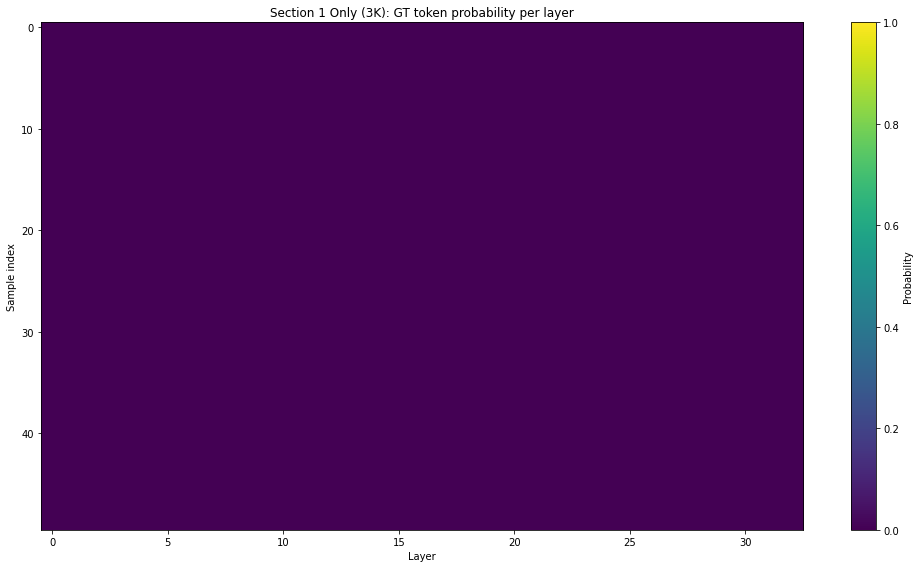

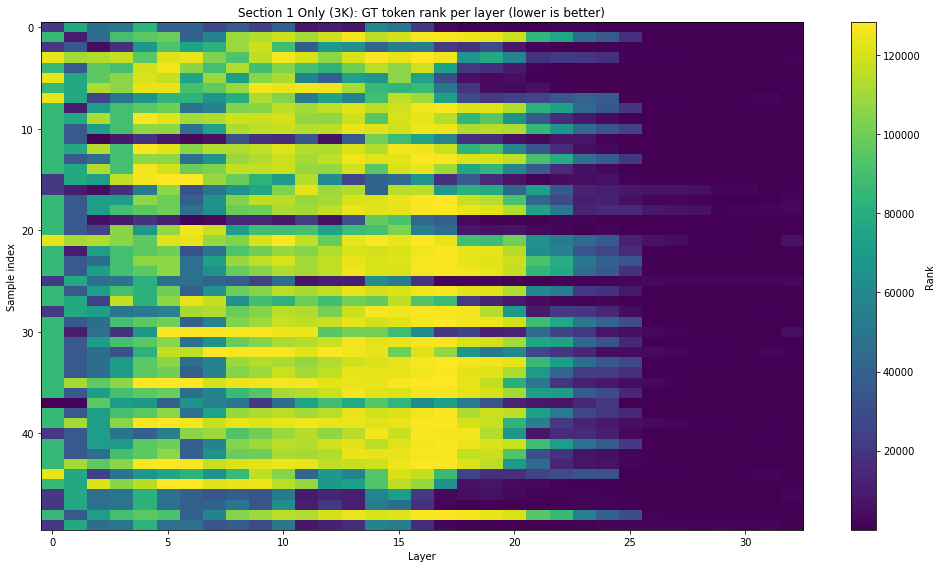

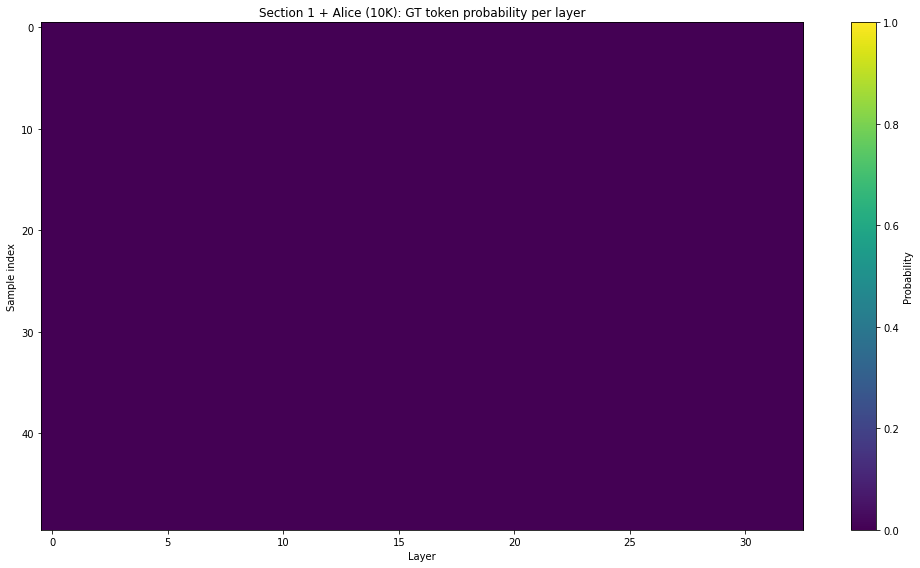

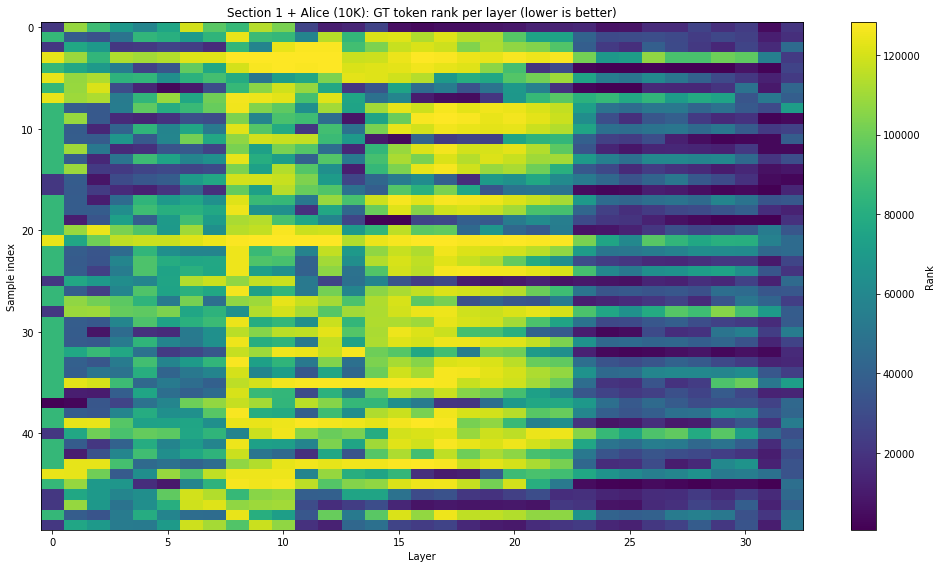

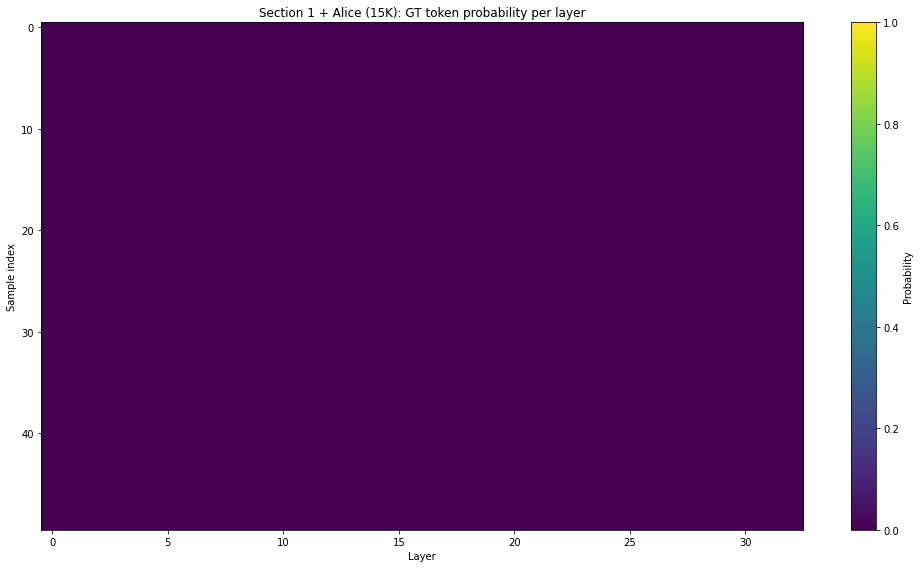

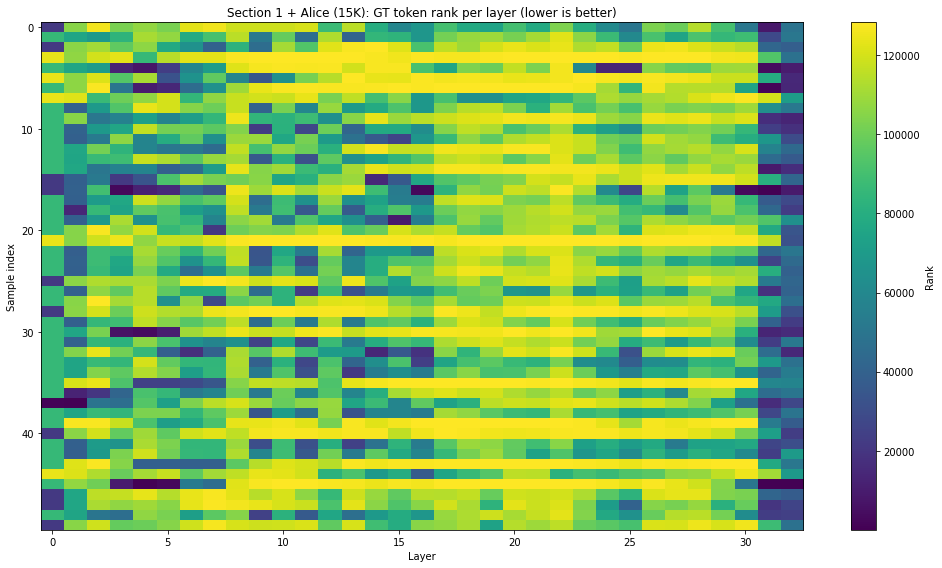

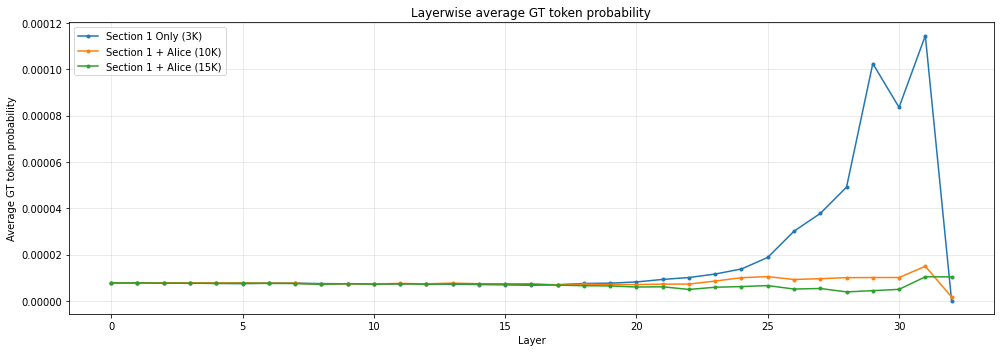

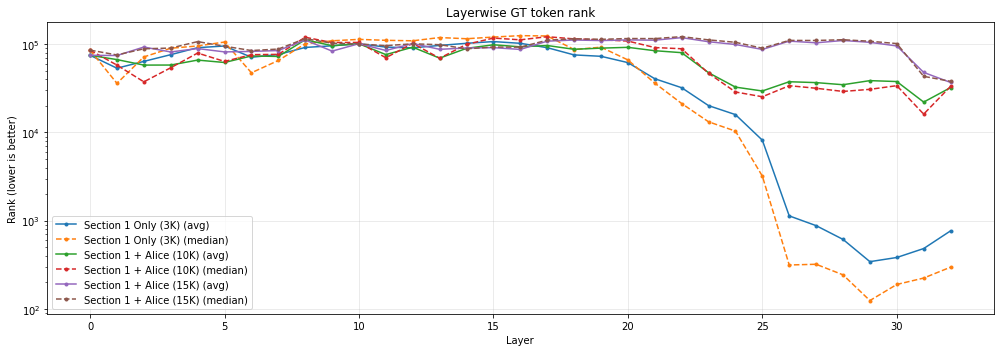


All plots saved to data/logit_lens_alice_degradation


In [17]:
# Analysis: Create heatmaps, analyze top predictions and ranks, check if top token starts with correct answer
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

# Load metadata
meta_df = pd.read_csv(OUT_DIR / "metadata.csv")

def check_top_token_match(top_token: str, correct_answer: str) -> bool:
    """Check if top token starts with the correct answer (case-insensitive)"""
    if not top_token or not correct_answer:
        return False
    
    top_token_clean = top_token.strip().lower()
    correct_clean = correct_answer.strip().lower()
    
    # Remove special characters and spaces for comparison
    top_token_clean = re.sub(r'[^a-z0-9]', '', top_token_clean)
    correct_clean = re.sub(r'[^a-z0-9]', '', correct_clean)
    
    # --- FIX STARTS HERE ---
    # Reject if the cleaned token is empty (e.g. prediction was "_" or "(")
    if len(top_token_clean) < 1:
        return False
    # -----------------------

    return (correct_clean.startswith(top_token_clean) or top_token_clean.startswith(correct_clean)) and len(correct_clean) >= 1

# Analyze final layer (last layer) performance
final_layer_idx = n_layers - 1

# Check top token matches for final layer for all three conditions
condition_names = ["section1_only", "section1_alice_10k", "section1_alice_15k"]
condition_labels = ["Section 1 Only (3K)", "Section 1 + Alice (10K)", "Section 1 + Alice (15K)"]
matches_dict = {name: [] for name in condition_names}

for i in range(N):
    gt_norm = meta_df.iloc[i]["gt_incorp_norm"]
    for cond_name in condition_names:
        # Handle cases where we might have processed fewer samples
        if i < len(results[cond_name]["top1_tokens"]):
            top1_list = results[cond_name]["top1_tokens"][i]
            if final_layer_idx < len(top1_list):
                top1 = top1_list[final_layer_idx]
            else:
                top1 = ""
            matches_dict[cond_name].append(check_top_token_match(top1, gt_norm))

# Print match rates
print(f"Final layer top token match rate:")
for cond_name, cond_label in zip(condition_names, condition_labels):
    if matches_dict[cond_name]:
        match_rate = sum(matches_dict[cond_name]) / len(matches_dict[cond_name])
        print(f"  {cond_label}: {match_rate:.3f} ({sum(matches_dict[cond_name])}/{len(matches_dict[cond_name])})")
    else:
        print(f"  {cond_label}: No data")

# Compute average ranks and probabilities per layer for all conditions
avg_probs_dict = {}
avg_ranks_dict = {}
median_ranks_dict = {}

for cond_name in condition_names:
    if len(results[cond_name]["probs"]) > 0:
        avg_probs_dict[cond_name] = results[cond_name]["probs"].mean(axis=0)
        avg_ranks_dict[cond_name] = results[cond_name]["ranks"].mean(axis=0)
        
        # Filter out invalid ranks (-1) for median calculation
        median_ranks = []
        for layer_idx in range(n_layers):
            ranks_layer = results[cond_name]["ranks"][:, layer_idx]
            valid = ranks_layer[ranks_layer >= 0]
            median_ranks.append(np.median(valid) if len(valid) > 0 else -1)
        median_ranks_dict[cond_name] = median_ranks
    else:
        # Handle empty results if any
        avg_probs_dict[cond_name] = np.zeros(n_layers)
        avg_ranks_dict[cond_name] = np.zeros(n_layers)
        median_ranks_dict[cond_name] = np.zeros(n_layers)

# Create summary DataFrame
summary_data = {"layer": range(n_layers)}
for cond_name, cond_label in zip(condition_names, condition_labels):
    summary_data[f"{cond_name}_avg_prob"] = avg_probs_dict[cond_name]
    summary_data[f"{cond_name}_avg_rank"] = avg_ranks_dict[cond_name]
    summary_data[f"{cond_name}_median_rank"] = median_ranks_dict[cond_name]

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv(OUT_DIR / "layerwise_summary.csv", index=False)
print(f"\nSaved layerwise summary to {OUT_DIR / 'layerwise_summary.csv'}")

# Plot heatmaps
def plot_heatmap(mat, title, outpath, vmin=None, vmax=None):
    if mat.size == 0: return
    plt.figure(figsize=(14, 8))
    im = plt.imshow(mat, aspect="auto", interpolation="nearest", vmin=vmin, vmax=vmax)
    plt.colorbar(im, label="Probability" if "prob" in title.lower() else "Rank")
    plt.xlabel("Layer")
    plt.ylabel("Sample index")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    plt.show()

# Probability heatmaps for all conditions
for cond_name, cond_label in zip(condition_names, condition_labels):
    plot_heatmap(results[cond_name]["probs"], 
                 f"{cond_label}: GT token probability per layer", 
                 OUT_DIR / f"heatmap_{cond_name}_probs.png",
                 vmin=0, vmax=1)
    
    # Rank heatmaps (only show valid ranks)
    ranks_plot = results[cond_name]["ranks"].copy().astype(float)  # Convert to float to allow NaN
    ranks_plot[ranks_plot < 0] = np.nan
    plot_heatmap(ranks_plot, 
                 f"{cond_label}: GT token rank per layer (lower is better)", 
                 OUT_DIR / f"heatmap_{cond_name}_ranks.png")

# Layerwise comparison plots
layers = np.arange(n_layers)
plt.figure(figsize=(14, 5))
for cond_name, cond_label in zip(condition_names, condition_labels):
    plt.plot(layers, avg_probs_dict[cond_name], label=cond_label, marker='o', markersize=3)
plt.xlabel("Layer")
plt.ylabel("Average GT token probability")
plt.title("Layerwise average GT token probability")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUT_DIR / "layerwise_avg_prob_comparison.png", dpi=150)
plt.show()

plt.figure(figsize=(14, 5))
for cond_name, cond_label in zip(condition_names, condition_labels):
    plt.plot(layers, avg_ranks_dict[cond_name], label=f"{cond_label} (avg)", marker='o', markersize=3)
    plt.plot(layers, median_ranks_dict[cond_name], label=f"{cond_label} (median)", linestyle='--', marker='o', markersize=3)
plt.xlabel("Layer")
plt.ylabel("Rank (lower is better)")
plt.title("Layerwise GT token rank")
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.savefig(OUT_DIR / "layerwise_rank_comparison.png", dpi=150)
plt.show()

print(f"\nAll plots saved to {OUT_DIR}")

In [18]:
import pandas as pd
import numpy as np
import json

# Load your results
out_dir = "data/logit_lens_alice_degradation"
top1_tokens_15k = json.load(open(f"{out_dir}/section1_alice_15k_top1_tokens.json"))
top1_tokens_10k = json.load(open(f"{out_dir}/section1_alice_10k_top1_tokens.json"))

# Get the final layer predictions
final_preds_15k = [sample_layers[-1] for sample_layers in top1_tokens_15k]
final_preds_10k = [sample_layers[-1] for sample_layers in top1_tokens_10k]

print("Most common predictions at 15k (The 'Recovery'):")
print(pd.Series(final_preds_15k).value_counts().head(5))

print("\nMost common predictions at 10k (The 'Crash'):")
print(pd.Series(final_preds_10k).value_counts().head(5))

Most common predictions at 15k (The 'Recovery'):
        8
 (      5
 the    4
 _      3
 -      2
dtype: int64

Most common predictions at 10k (The 'Crash'):
 The        20
 and        19
 the         5
 waste       1
 Peoples     1
dtype: int64
